### Neural Network Classification with Pytorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options).

### 1. Data - Make classification dataset ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
y[0]

1

In [5]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### Note: The data we're working with is often referred to as toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals

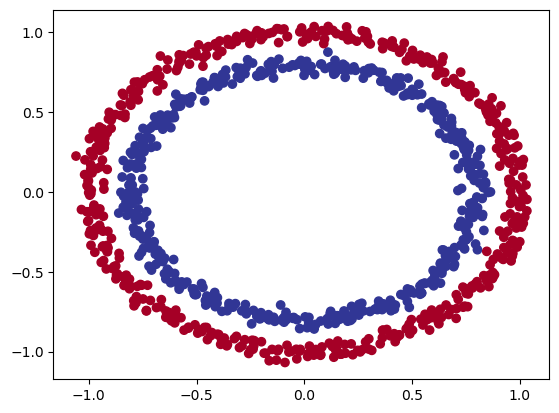

In [6]:
# Let's visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes
We need to turn our data (toy dataset) from numpy ndarrays to Pytorch Tensors for manipulation in Neural Networks

In [7]:
# View the first sample of X and y or features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
import numpy as np
torch.__version__

'2.4.1'

In [9]:
# Turn data into tensors
def numpy_to_torch(x: np.ndarray, device="cpu") -> torch.Tensor:
    return torch.from_numpy(x).type(torch.float32).to(device)

In [10]:
# Torch tensors to numpy ndarrays
def torch_to_numpy(x: torch.Tensor) -> np.ndarray:
    return torch.Tensor(x).cpu().squeeze().type(torch.double).numpy()

In [11]:
X = numpy_to_torch(X)

In [12]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [13]:
y = numpy_to_torch(y)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 1.3 Build a model 
Let's build a model to classify our red and blue dots. <br />
To do so, we want to:
1. Setup device agnostic code so our code can run on an accelerator (GPU) if there is one
2. Construct a model by subclassing `nn.Module`
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import Pytorch and nn
import torch
from torch import nn

# Run device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [17]:
# Putting the data on to the device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Now we've set up device agnostic code, let's create a model that: 
1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward propagation or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [21]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # takes in 5 features as input from previous layer and outputs a single feature (same shape as y)
    # 3. Define a forward() method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x -> layer1 -> layer2 -> output
        
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
# Check on which device our model resides in
next(model_0.parameters()).device

device(type='mps', index=0)

In [23]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6766,  0.4977],
                      [-0.6535,  0.0292],
                      [-0.1596,  0.2630],
                      [ 0.3200,  0.6266],
                      [ 0.3212, -0.6049]], device='mps:0')),
             ('0.bias',
              tensor([-0.3807,  0.5952, -0.6765,  0.3627, -0.2541], device='mps:0')),
             ('1.weight',
              tensor([[-0.1366, -0.2454, -0.3851,  0.1214, -0.1264]], device='mps:0')),
             ('1.bias', tensor([0.3840], device='mps:0'))])

In [25]:
# Make predictions
with torch.inference_mode():
    untrained_pred = model_0(X_test)
print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {torch.round(untrained_pred[:10])}")
print(f"\nFirst 10 labels: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0')

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0')


### 2.1 Setup a loss function and optimizer
Which loss function or optimizer should we use? Again... this is problem specific <br />
For example, for **regression** problems we can use **MAE (Mean Absolute Error or L1 Loss)** or **MSE (Mean Squared Error or L2 Loss)** <br />
For **classification** we can use **binary cross entropy** or **categorical cross entropy (cross entropy)** <br />
As a reminder, the loss functions measures how *wrong* our model's predictions are. <br />
And for optimizers, two of the most and useful are **SGD** and **Adam**, however Pytorch has many built-in options. <br />
For the loss function we are going to use `torch.nn.BCEWithLogitsLoss()`

In [26]:
# Set up the loss function
# loss_fn = nn.BCELoss()  # BCELoss requires the inputs to have gone through the sigmoid acitvation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss() has the sigmoid activation function built-in

# Set up the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [27]:
# Calculate accuracy - out of 100 examples, what percentage does our model classify correctly?
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc 

### 2.2 Training our model
To train our model, we require a training loop with the following steps: 
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 2.3 Going from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw **logits** <br />
We can convert these **logits** into **prediction probabilities** by passing them into some kind of activation funtion (eg, sigmoid for binary classification and softmax for multi-class classification) <br />
Then we can convert those prediction probabilities into **prediction labels** by either rounding them or taking the `argmax()`

In [31]:
tensor = torch.Tensor([4, 2, 3, 10]).type(torch.float).to(device)
max = torch.argmax(tensor)
print(max, tensor[max])

tensor(3, device='mps:0') tensor(10., device='mps:0')


In [32]:
# View the first 5 outputs of the forward pass on test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[0.5624],
        [0.6056],
        [0.5444],
        [0.5671],
        [0.6958]], device='mps:0')

In [33]:
# Use the sigmoid activation function on our model to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6370],
        [0.6469],
        [0.6328],
        [0.6381],
        [0.6672]], device='mps:0')

For our prediction probability values, we need to perform a range-style rounding:
- `y_pred_probs` >= 0.5, `y = 1` (class 1)
- `y_pred_probs` < 0.5, `y = 0` (class 0)

In [34]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

# Check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0')

In [35]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='mps:0')

### 3. Building a training and testing loops

In [36]:
X_train.device, y_train.device, X_test.device, y_test.device

(device(type='mps', index=0),
 device(type='mps', index=0),
 device(type='mps', index=0),
 device(type='mps', index=0))

In [37]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000

# Put data to target device -> we already have done this before 
# Build training and test loops
for epoch in range(epochs):
    # Put the model in training mode
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # turn logits -> pred probs -> pred labels

    # 2. Calculate the loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train)  # nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train)  # As we are using BCEWithLogitsLoss, we pass in the logits. This is more numerically stable than BCELoss
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))  # turns logits -> pred probs -> pred labels

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Accuracy: {acc:.3f}% | Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}%")

Epoch: 0 | Loss: 0.742 | Accuracy: 50.000% | Test loss: 0.738 | Test accuracy: 50.000%
Epoch: 10 | Loss: 0.710 | Accuracy: 50.000% | Test loss: 0.710 | Test accuracy: 50.000%
Epoch: 20 | Loss: 0.700 | Accuracy: 50.125% | Test loss: 0.701 | Test accuracy: 51.500%
Epoch: 30 | Loss: 0.696 | Accuracy: 53.125% | Test loss: 0.698 | Test accuracy: 51.500%
Epoch: 40 | Loss: 0.695 | Accuracy: 51.625% | Test loss: 0.697 | Test accuracy: 50.500%
Epoch: 50 | Loss: 0.695 | Accuracy: 51.375% | Test loss: 0.697 | Test accuracy: 51.000%
Epoch: 60 | Loss: 0.694 | Accuracy: 51.250% | Test loss: 0.696 | Test accuracy: 51.000%
Epoch: 70 | Loss: 0.694 | Accuracy: 50.875% | Test loss: 0.696 | Test accuracy: 51.000%
Epoch: 80 | Loss: 0.694 | Accuracy: 50.875% | Test loss: 0.696 | Test accuracy: 51.000%
Epoch: 90 | Loss: 0.694 | Accuracy: 50.750% | Test loss: 0.696 | Test accuracy: 49.500%
Epoch: 100 | Loss: 0.694 | Accuracy: 50.875% | Test loss: 0.695 | Test accuracy: 49.500%
Epoch: 110 | Loss: 0.693 | Accur

In [38]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

### 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything... <br />
So to inspect let's make some predictions and make them visual! <br />
In other words, "visualize, outline and code" <br />
To do so, we're going to import a function `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [40]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

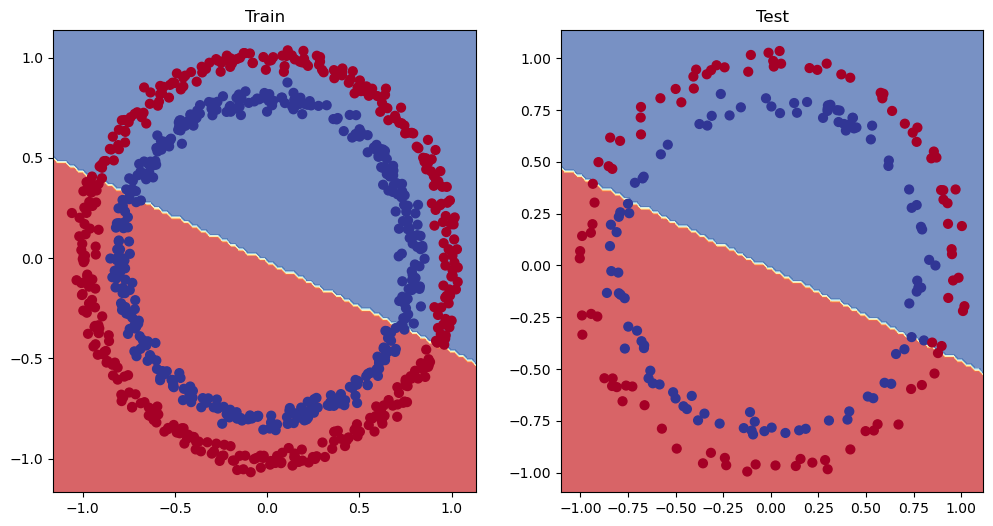

In [41]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # rows, cols, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)  # rows, cols, index
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving a model (from a model's perspective)
- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer (train the model through more epochs)
- Changing the activation function
- Change the learning rate
- Change the loss function
  
These options are all from model's perspective because they deal directly with the model, rather than the data. <br />
And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparameters** <br />
Let's try and improve our model by:
- Adding more hidden units (5 -> 10)
- Increase the no of layers (2 -> 3)
- Increase the no of epochs (1000 -> 10000)

Generally, we would not incorporate all these changes in one time, rather going incrementally from one change to other change (known as **experiment tracking** in machine learning)

In [43]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))  # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
next(model_1.parameters()).device

device(type='mps', index=0)

In [45]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222,

In [48]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [52]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device for compatibility with device agnostic code
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    # Put the model in train mode
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()  # squeeze to get rid of an extra dimension
    # raw logits -> pred prob -> pred labels
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_preds, y_true=y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimzer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        # test logits -> pred prob -> pred labels
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_preds, y_true=y_test)

    # Print out what's happenin'
    if(epoch % 100 == 0):
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Train Accuracy: {acc:.3f}% | Test loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}%")
        

Epoch: 0 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 100 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 200 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 300 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 400 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 500 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 600 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 700 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 800 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 46.000%
Epoch: 900 | Train loss: 0.693 | Train Accuracy: 51.000% | Test loss: 0.695 | Test Accuracy: 

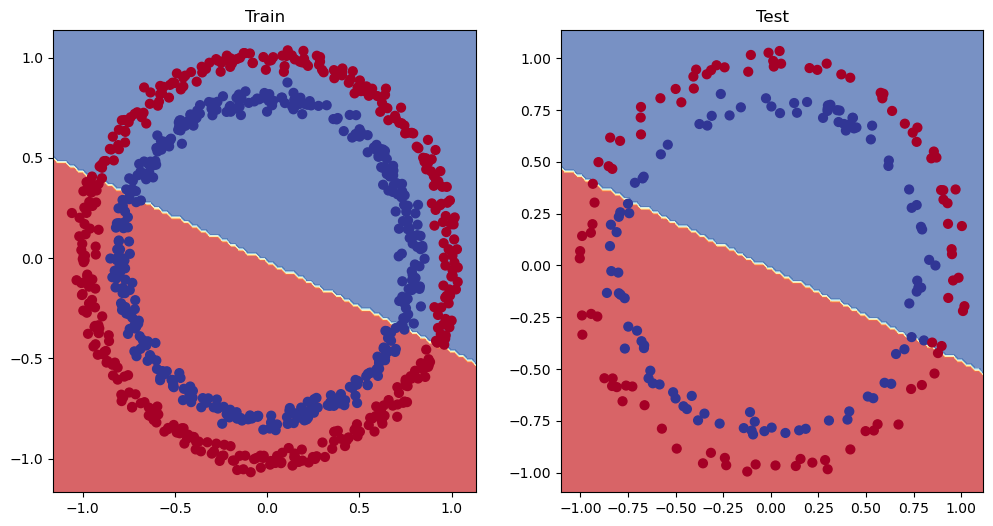

In [53]:
# Plot the decision boundary for the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot a larger problem is to test out a smaller problem

In [70]:
# Create some data (same as notebook 01)
weight = 0.7 
bias = 0.3
start = 0
end = 1 
step = 0.01 

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [71]:
# Create the training and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression, X_test_regression, y_test_regression = X_regression[:train_split], y_regression[:train_split], X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

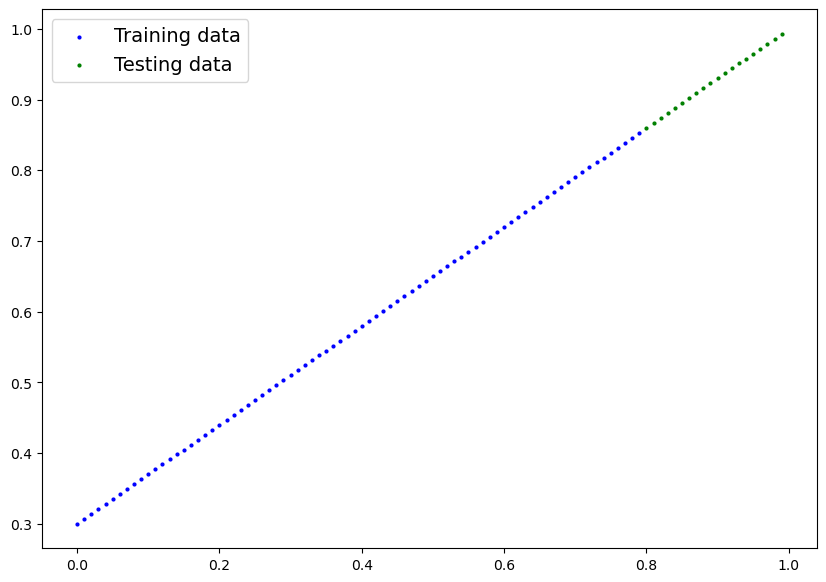

In [57]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### 5.2 Adjusting our model to fit a straight line 

In [58]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [81]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [85]:
# Train the model
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Set the no of epochs
epochs = 10000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device) 

for epoch in range(epochs):
    ### Training
    model_2.train()

    # 1. Forward pass
    y_preds = model_2(X_train_regression)

    # 2. Calculate the loss 
    loss = loss_fn(y_preds, y_train_regression)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
        test_loss = loss_fn(test_preds, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.2f} | Test loss: {test_loss:.2f}")

Epoch: 0 | Train loss: 0.04 | Test loss: 0.09
Epoch: 100 | Train loss: 0.06 | Test loss: 0.02
Epoch: 200 | Train loss: 0.05 | Test loss: 0.04
Epoch: 300 | Train loss: 0.04 | Test loss: 0.05
Epoch: 400 | Train loss: 0.06 | Test loss: 0.02
Epoch: 500 | Train loss: 0.06 | Test loss: 0.02
Epoch: 600 | Train loss: 0.05 | Test loss: 0.03
Epoch: 700 | Train loss: 0.08 | Test loss: 0.05
Epoch: 800 | Train loss: 0.05 | Test loss: 0.04
Epoch: 900 | Train loss: 0.05 | Test loss: 0.08
Epoch: 1000 | Train loss: 0.06 | Test loss: 0.11
Epoch: 1100 | Train loss: 0.04 | Test loss: 0.08
Epoch: 1200 | Train loss: 0.06 | Test loss: 0.11
Epoch: 1300 | Train loss: 0.05 | Test loss: 0.12
Epoch: 1400 | Train loss: 0.05 | Test loss: 0.08
Epoch: 1500 | Train loss: 0.07 | Test loss: 0.09
Epoch: 1600 | Train loss: 0.05 | Test loss: 0.11
Epoch: 1700 | Train loss: 0.06 | Test loss: 0.09
Epoch: 1800 | Train loss: 0.05 | Test loss: 0.13
Epoch: 1900 | Train loss: 0.06 | Test loss: 0.11
Epoch: 2000 | Train loss: 0.06 |

In [86]:
X_train_regression.device

device(type='mps', index=0)

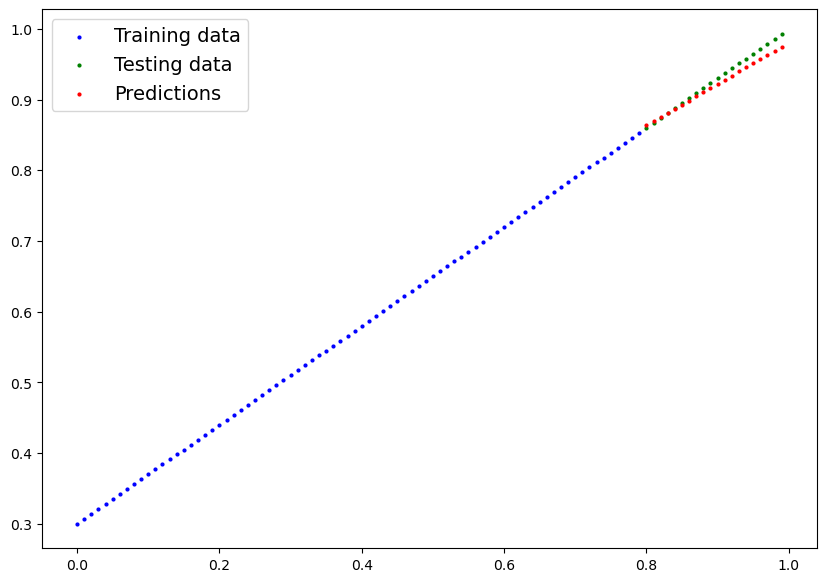

In [87]:
# Turn on evaluation mode
model_2.eval()

# Make predictions on our model (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# NOTE THAT BEFORE PLOTTING WE NEED TO BRING OUR DATA BACK ON CPU AS MATPLOTLIB SUPPORTS DATA ON CPU (NUMPY)
# Plot the data and predictions 
plot_predictions(train_data=X_train_regression.cpu(), 
                 train_labels=y_train_regression.cpu(), 
                 test_data=X_test_regression.cpu(), 
                 test_labels=y_test_regression.cpu(), 
                 predictions=y_preds.cpu())           

### 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of straight and non-straight lines ?"

Or in machine learning terms, an infinite (but really is finite) amount of linear and non-linear functions? 

### 6.1 Recreating non-linear data (red and blue circles)

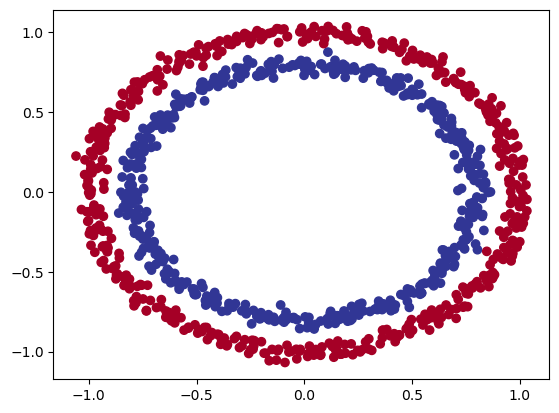

In [94]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles 

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [99]:
# Convert data to tensors and then to train and test splits 
import torch
from sklearn.model_selection import train_test_split

# Turn data to tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# Split into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='mps:0'),
 tensor([1., 0., 0., 0., 1.], device='mps:0'))

### 6.2 Building a model with non-linearity
Artificial Neural Networks are a combination of linear (straight) and non-linear (non-straight) functions which are potentially able to find patterns in the data 

In [101]:
# Build a model with non-linear activation functions 
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()  # relu is a non-linear activation function

    def forward(self, x):
        # Where should we put our non-linear activation function?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [102]:
next(model_3.parameters()).device

device(type='mps', index=0)

In [103]:
# Set up the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [109]:
# Random seeds 
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Put all the data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Training
# Set no of epochs
epochs = 10000
for epoch in range(epochs):
    # Put the model in train mode
    model_3.train()

    # 1. Forward
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))  # logits -> pred prob -> pred labels

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test)

    # Print out what's happening
    if(epoch % 100 == 0):
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Train accuracy: {acc:.3f}% | Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}% ")

Epoch: 0 | Train loss: 0.667 | Train accuracy: 61.125% | Test loss: 0.665 | Test accuracy: 62.000% 
Epoch: 100 | Train loss: 0.656 | Train accuracy: 64.250% | Test loss: 0.657 | Test accuracy: 65.000% 
Epoch: 200 | Train loss: 0.639 | Train accuracy: 67.375% | Test loss: 0.643 | Test accuracy: 69.000% 
Epoch: 300 | Train loss: 0.607 | Train accuracy: 74.000% | Test loss: 0.618 | Test accuracy: 74.500% 
Epoch: 400 | Train loss: 0.548 | Train accuracy: 90.000% | Test loss: 0.566 | Test accuracy: 85.000% 
Epoch: 500 | Train loss: 0.449 | Train accuracy: 96.750% | Test loss: 0.476 | Test accuracy: 94.500% 
Epoch: 600 | Train loss: 0.325 | Train accuracy: 99.000% | Test loss: 0.357 | Test accuracy: 98.500% 
Epoch: 700 | Train loss: 0.212 | Train accuracy: 99.875% | Test loss: 0.247 | Test accuracy: 99.000% 
Epoch: 800 | Train loss: 0.157 | Train accuracy: 99.750% | Test loss: 0.193 | Test accuracy: 99.000% 
Epoch: 900 | Train loss: 0.107 | Train accuracy: 99.875% | Test loss: 0.141 | Test a

In [110]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-2.0208, -0.4634],
                      [-1.7024,  2.3216],
                      [-3.1028,  0.4994],
                      [ 0.2485,  0.2298],
                      [ 0.6186,  3.3235],
                      [ 0.1554,  0.0910],
                      [-2.5213,  1.1902],
                      [ 1.3149, -1.1931],
                      [ 0.6074,  0.1576],
                      [-2.2728, -2.3253]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3047, -0.4470, -0.5784, -0.4035, -0.1564, -0.5283,  2.9934,  1.3713,
                      -0.6657, -0.1566], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 1.6291e-01,  7.7184e-02, -1.2150e-01,  1.6505e-01,  2.1564e-01,
                        1.1825e-01, -5.3711e-02, -8.3299e-02,  3.3830e-02, -5.5863e-02],
                      [ 3.9097e-01,  1.4721e+00,  1.6391e+00, -3.1306e-02,  1.2009e+00,
                        4.6145e-03,  5.1022e-02, 

### 6.4 Evaluating a model trained with non-linear activation function

In [113]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-2.0208, -0.4634],
                      [-1.7024,  2.3216],
                      [-3.1028,  0.4994],
                      [ 0.2485,  0.2298],
                      [ 0.6186,  3.3235],
                      [ 0.1554,  0.0910],
                      [-2.5213,  1.1902],
                      [ 1.3149, -1.1931],
                      [ 0.6074,  0.1576],
                      [-2.2728, -2.3253]])),
             ('layer_1.bias',
              tensor([-0.3047, -0.4470, -0.5784, -0.4035, -0.1564, -0.5283,  2.9934,  1.3713,
                      -0.6657, -0.1566])),
             ('layer_2.weight',
              tensor([[ 1.6291e-01,  7.7184e-02, -1.2150e-01,  1.6505e-01,  2.1564e-01,
                        1.1825e-01, -5.3711e-02, -8.3299e-02,  3.3830e-02, -5.5863e-02],
                      [ 3.9097e-01,  1.4721e+00,  1.6391e+00, -3.1306e-02,  1.2009e+00,
                        4.6145e-03,  5.1022e-02, -8.7901e-01,  8.8618e-02,  1.384

In [115]:
# Make predictions 
model_3.to(device)  # The model weights were on cpu so we got a RuntimeError, so had to write this line of code
model_3.eval()
with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

test_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

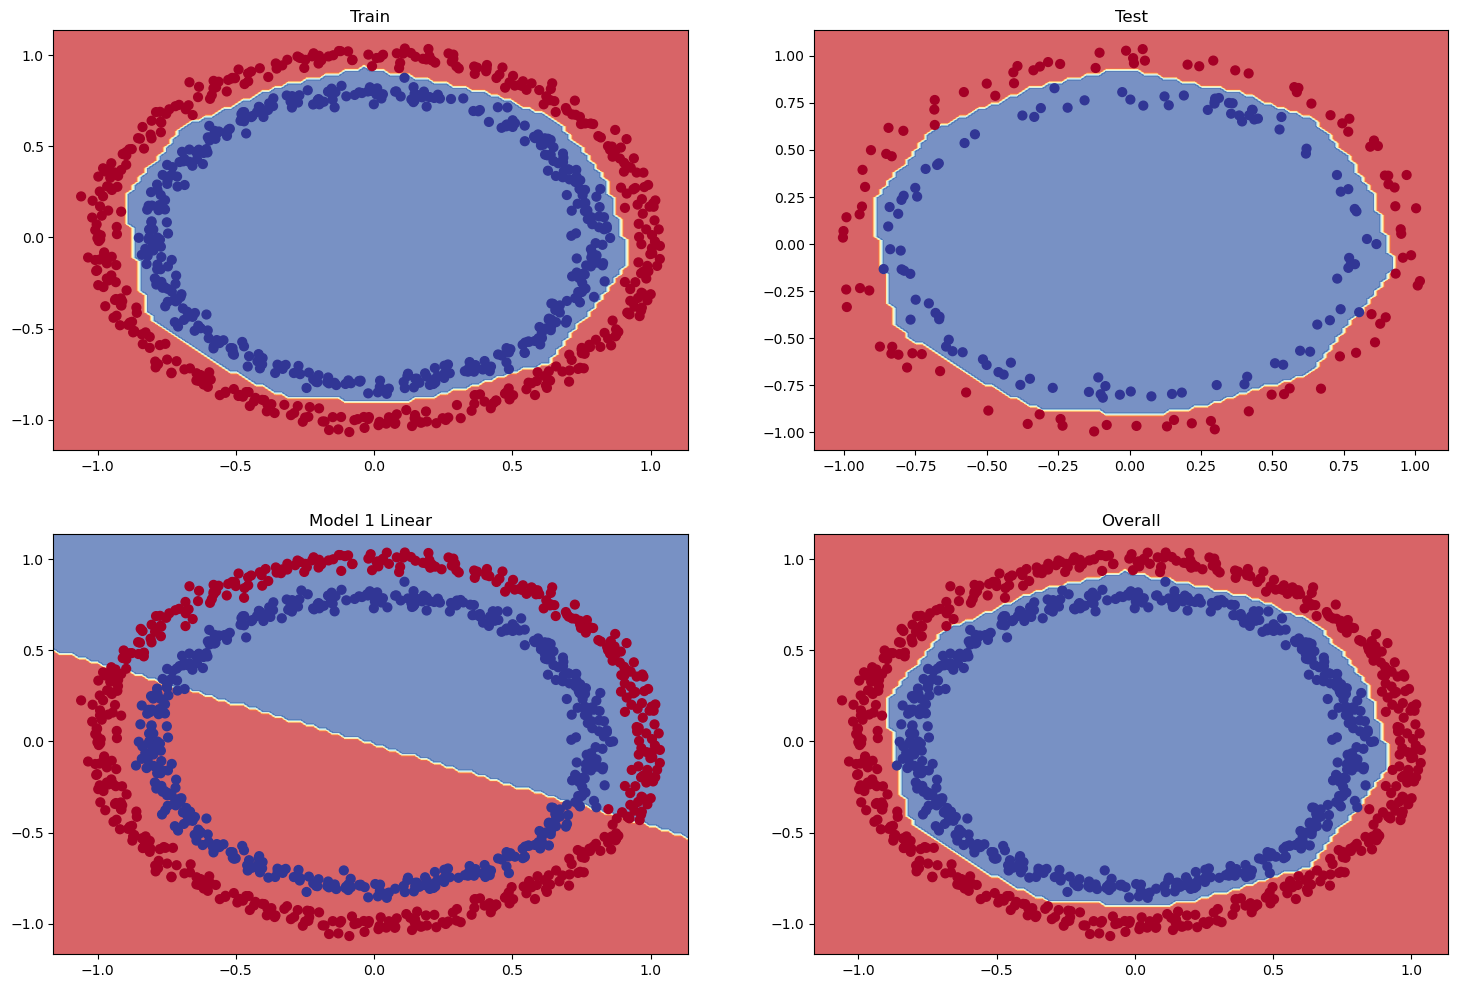

In [123]:
# Plot decision boundaries
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(2, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.subplot(2, 2, 3)
plt.title("Model 1 Linear")
plot_decision_boundary(model_1, X, y)
plt.subplot(2, 2, 4)
plt.title("Overall")
plot_decision_boundary(model_3, X, y)

### 7. Replicating non-linear activation functions 
Neural Networks rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions 